### Requirements
- pandas
- numpy
- hanspell
- matplotlib
- seaborn
- argparse
- symspellpy_ko

In [9]:
!unzip hanspell.zip

Archive:  hanspell.zip
 extracting: hanspell/__init__.py    
   creating: hanspell/__pycache__/
  inflating: hanspell/__pycache__/__init__.cpython-39.pyc  
  inflating: hanspell/__pycache__/constants.cpython-39.pyc  
  inflating: hanspell/__pycache__/response.cpython-39.pyc  
  inflating: hanspell/__pycache__/spell_checker.cpython-39.pyc  
  inflating: hanspell/constants.py   
  inflating: hanspell/response.py    
  inflating: hanspell/spell_checker.py  


In [10]:
import os

import pandas as pd
import numpy as np
import hanspell
from hanspell import spell_checker    # !unzip hanspell.zip
from symspellpy_ko import KoSymSpell, Verbosity
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv')
dev = pd.read_csv('dev.csv')






---


## Preprocessing (데이터 전처리)

## 1. 특수문자 제거
- 모델에 적용 시 오히려 성능이 떨어지는 결과가 있어 사용하지 않음

In [ ]:
train['sentence_1_regex'] = train['sentence_1'].str.replace(pat=r'[^\w]', repl=r' ',regex=True).str.strip()
train['sentence_2_regex'] = train['sentence_2'].str.replace(pat=r'[^\w]', repl=r' ',regex=True).str.strip()





---


## 2. 맞춤법 교정
- hanspell, spell_checker
  - 파이썬 한글 맞춤법 검사 라이브러리. (네이버 맞춤법 검사기 사용)
  - 띄어쓰기 · 오타 · 맞춤법 교정
- Symspell
  -  오타교정, 유사검색어 제안에 활용되는 라이브러리
  -  띄어쓰기 · 오타 · 맞춤법 교정, 특수문자 제거
  -  max_edit_distance 에 따라 교정정도가 달라진다. 0와 1의 차이가 너무 심해 미사용
    - max_edit_distance = 0 : 띄어쓰기, 특수 문자 제거 정도, 본문과 비슷함
    - max_edit_distance > 1 : 기존과 전혀 다른 단어를 생성하는 등 이상한 결과

###2-1. hanspell, spell_checker (py-hanspell)
- pearcon : 0.91957 로 기존 train dataset과 성능이 비슷하여 사용
- model : snunlp_KR-ELECTRA-discriminator / lr :1.6e-05

In [ ]:
def hanspell_apply() :
    train = pd.read_csv(args.read_path)

    s1_results = []
    s2_results = []

    string_list_1 = train['sentence_1'].tolist()
    string_list_2 = train['sentence_2'].tolist()
    # print(type(string))

    i=0
    for s in string_list_1:
        try:
            r = spell_checker.check(s)
            s1_results.append(r.checked)
            # if i%500 == 0 :
            #   print(i," ; ",s, " / ", r.checked)
        except Exception as e:
            s1_results.append(s)
        i += 1

    for s in string_list_2:
        try:
            r = spell_checker.check(s)
            s2_results.append(r.checked)
        except Exception as e:
            s2_results.append(s)

    # 리스트를 DataFrame에 열로 추가
    train['s1'] = s1_results
    train['s2'] = s2_results

    col = ['id','source','s1','s2','label','binary-label']
    train = train[col]
    train.columns = ['id','source','sentence_1','sentence_2','label','binary-label']


    train.to_csv(args.save_path, sep=",", index = False)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--read_path', default='./data/train.csv', type=str)
    parser.add_argument('--save_path', default='./data/hanspell_train.csv', type=str)
    args = parser.parse_args()
    hanspell_apply()

###2-2. Symspell (symspellpy_ko)

In [ ]:
sym_spell = KoSymSpell()
sym_spell.load_korean_dictionary(decompose_korean=True, load_bigrams=True)
# help( KoSymSpell.lookup_compound)

In [ ]:
def Symspell_apply() :
    train = pd.read_csv(args.read_path)

    # lookup_compound로 띄어쓰기 및 오타교정
    text1 = train['sentence_1']
    text2 = train['sentence_2']

    s1_results = []
    s2_results = []

    for t in text1:
        try:
            suggestions = sym_spell.lookup_compound(t, max_edit_distance=1)
            if suggestions:
                s1_results.append(suggestions[0].term)
            else:
                s1_results.append(t)
        except (KeyError, IndexError):
            # KeyError 또는 IndexError 발생 시 원래 문장 유지
            s1_results.append(t)

    for t in text2:
        try:
            suggestions = sym_spell.lookup_compound(t, max_edit_distance=1)
            if suggestions:
                s2_results.append(suggestions[0].term)
            else:
                s2_results.append(t)
        except (KeyError, IndexError):
            # KeyError 또는 IndexError 발생 시 원래 문장 유지
            s2_results.append(t)

    # 리스트를 DataFrame에 열로 추가
    train['s1'] = s1_results
    train['s2'] = s2_results

    col = ['id','source','s1','s2','label','binary-label']
    train = train[col]
    train.columns = ['id','source','sentence_1','sentence_2','label','binary-label']


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--read_path', default='./data/train.csv', type=str)
    parser.add_argument('--save_path', default='./data/Symspell_train.csv', type=str)
    args = parser.parse_args()
    Symspell_apply()





---


##3. Data Augmentation (DA)

### 3-1. Swap Sentence
- sentence_1과 sentence_2 의 순서를 변경하는 방법
- 두 문장의 순서가 바뀌어도 유사도(label)는 동일함이 객관적으로 보장된다.
- sentence_1과 sentence_2 의 Segment Embedding 값이 다르므로, 변경 시 유의미한 데이터 증강이 될 것이라고 분석했으나,

  모델성능이 오히려 떨어지는 결과가 나와 채택X
- Segment Embedding : 단어가 첫번째 문장에 속하는지 두번째 문장에 속하는지 알려준다.


In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train['s_sentence1'] = train['sentence_2']
train['s_sentence2'] = train['sentence_1']


col1 = ['id','source','sentence_1','sentence_2','label','binary-label']
df1 = train[col1]
col2 = ['id','source','s_sentence1','s_sentence2','label','binary-label']
df2 = train[col2]
df2.columns = ['id','source','sentence_1','sentence_2','label','binary-label']

swap_train = pd.concat([df1, df2], axis=0, ignore_index=True)

### 3-2. BERT_Augmentation (Random Masking Insertion)
- from K_TACC.BERT_augmentation import BERT_Augmentation
  - random_masking_insertion 증강 방법 사용
  - 참조 ) [문맥을 고려한 한국어 텍스트 데이터 증강](https://github.com/kyle-bong/K-TACC.git)
  - [data_augmentation.py](https://github.com/boostcampaitech6/level1-semantictextsimilarity-nlp-09/blob/main/data_augmentation.py)

###3-3. label Smoothing 후 증강
- label 0 의 개수가 너무 많아 bert augmentation(no drop)을 해도 uniform 해지지 않았다.
- hanspell 이용

- 1) Label 5 증강
  - Label 0 과 Label 5의 갯수가 비슷해질 때까지 ['sentence_1'] = hanspell_apply(Label 0의 ['sentence_2']) : Copied Translation + hanspell
  - ['label'] = 5.0 . [binary_label'] = 1.0

- 2) 나머지
  - 분포가 집중된 구간 제외하고 hanspell_apply() 2배 증강
  - dev와 분포 비슷하게 하기 위함

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv('aug_nodrop_train.csv')
dev = pd.read_csv('dev.csv')

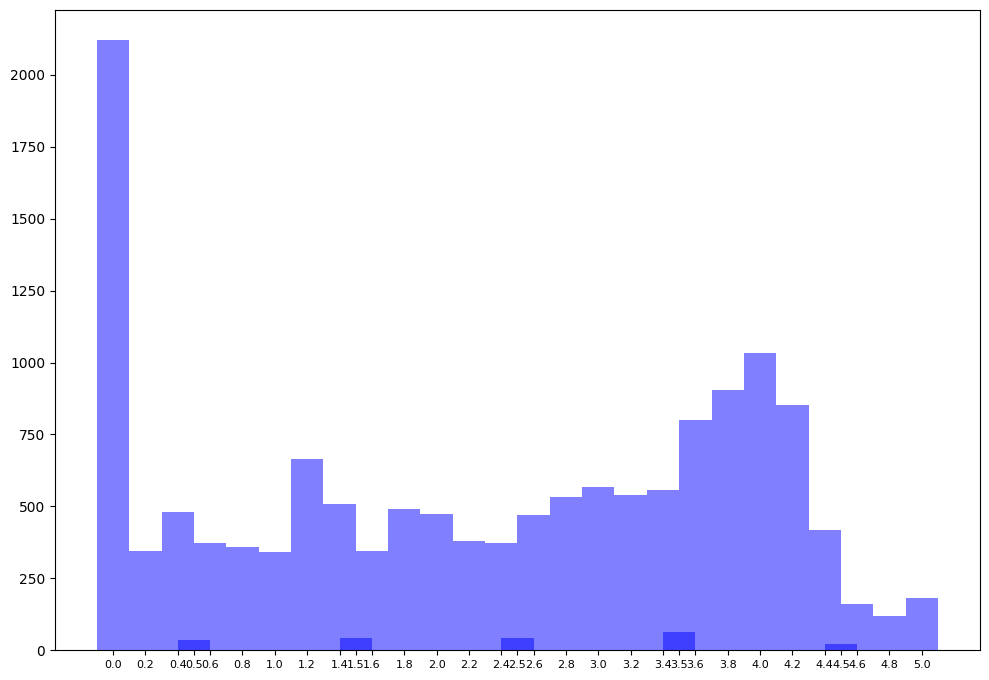

In [25]:
feature = train['label']

plt.figure(figsize=(10,7.5))
#plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.2, color='b', alpha=0.5)
plt.xticks(temp.keys(), fontsize=8) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기
# label == 0 :: 2119

In [26]:
# 1/2 drop : 0 Label -> delete된 것 1/2 label 5, binary_label 1
target_count = len(train[train['label'] == 0])/2
i = 0

while len(train[train['label'] == 0]) > target_count:
    mask = (train['label'] == 0)
    target_index = train[mask].sample(n=1).index[0]
    train.at[target_index, 'label'] = 5
    train.at[target_index, 'binary-label'] = 1
    s = train.at[target_index, 'sentence_2']
    try:
      r = spell_checker.check(s)
      train.at[target_index,'sentence_1'] = r.checked
       # if i%500 == 0 :
       #   print(i," ; ",s, " / ", r.checked)
    except Exception as e:
      train.at[target_index,'sentence_1'] = train.at[target_index, 'sentence_2']
        #print('error')
    if i % 200 == 0 :
      print(f'[{i}]')
      print("sen1: ",train.at[target_index,'sentence_1'])
      print("sen2: ",train.at[target_index,'sentence_2'])
      print("label: ",train.at[target_index,'label'])
      print("binary-label: ",train.at[target_index,'binary-label'])
    i += 1


[0]
sen1:  다시 보기에서 봤는데 몇 날 며칠 동안 울기만 했음
sen2:  다시보기에서 봤는데 몇날 며칠동안 울기만했음
label:  5.0
binary-label:  1.0
[200]
sen1:  감동의 도가니ㅠㅠㅠ
sen2:  감동의 도가니ㅠㅠㅠ
label:  5.0
binary-label:  1.0
[400]
sen1:  유머가 아니라 진심이신듯요. ㅋㅋ
sen2:  유머가 아니라 진심이신듯요. ㅋㅋ
label:  5.0
binary-label:  1.0
[600]
sen1:  그래서 OKR을 팀 단위까지 내리는 것이 필요한 것 같아요.
sen2:  그래서 OKR을 팀 단위까지 내리는 것이 필요한 것 같아요.
label:  5.0
binary-label:  1.0
[800]
sen1:  8크루를 다 보신다니 부럽습니다.
sen2:  8크루를 다 보신다니 부럽습니당.
label:  5.0
binary-label:  1.0
[1000]
sen1:  김성태 의원 폭행범 징역 1년은 너무 심합니다
sen2:  김성태의원 폭행범 징역1년은 너무 심합니다
label:  5.0
binary-label:  1.0


In [35]:
dev = pd.read_csv('dev.csv')

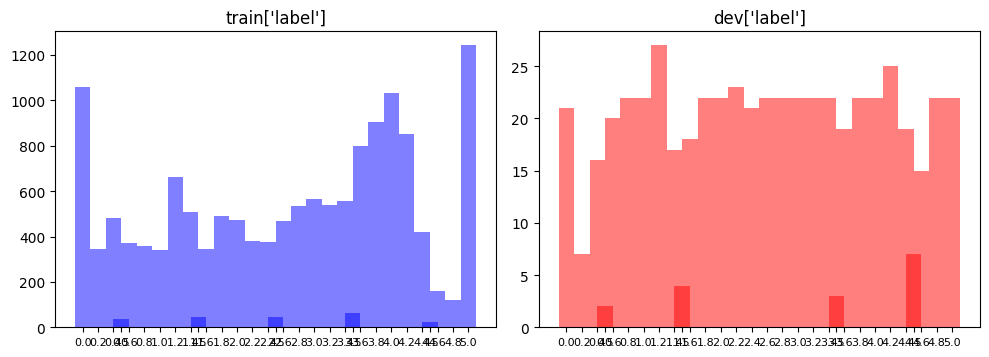

In [36]:
# For train data
feature_train = train['label']
temp_train = feature_train.value_counts()

# For dev data
feature_dev = dev['label']
temp_dev = feature_dev.value_counts()

# subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# train data 그래프
ax1.bar(temp_train.keys(), temp_train.values, width=0.2, color='b', alpha=0.5)
ax1.set_title('train[\'label\']')
ax1.set_xticks(temp_train.keys())
ax1.set_xticklabels(temp_train.keys(), fontsize=8)

# dev data 그래프
ax2.bar(temp_dev.keys(), temp_dev.values, width=0.2, color='r', alpha=0.5)
ax2.set_title('dev[\'label\']')
ax2.set_xticks(temp_dev.keys())
ax2.set_xticklabels(temp_dev.keys(), fontsize=8)

# 레이아웃 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Two-Sample Kolmogorov-Smirnov Test
- 2개의 표본 누적 확률분호가 동일한지 비교
- 전처리의 전, 후 결과를 조금 더 정량적으로 비교하기 위해 방법
- 두 개의 sample 집합을 보고 같은 probability distribution에서 추출되었는지 확인

In [38]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(train['label'], dev['label'])

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")
# 귀무가설 기각하므로 분포가 같다고 할 수 없다. (0.05/0.025)

KS Statistic: 0.06572176025413434
P-value: 0.019610133425375747


In [39]:
df = pd.DataFrame(columns=train.columns)
df = train.copy()

# 이미 충분한 label 대역대 제외
con1 = df['label'] >0.2
con2 = ((df['label'] < 3.6) | (df['label'] > 4.4))
con3 = df['label'] != 5

df = df[con1 & con2 & con3]
df.columns

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')

In [40]:
s_results = []

string_list = df['sentence_1'].tolist()
i = -1

for s in string_list:
    i += 1
    try:
        r = spell_checker.check(s)
        s_results.append(r.checked)
        if i%500 == 0 :
          print(i," ; ",s, " / ", r.checked)
    except Exception as e:
        s_results.append(s)
        print('error')

# 리스트를 DataFrame에 열로 추가
#print(s2_results)
print(s_results)
df.loc[:,'hanspells1'] = s_results.copy()

df_final = df[['id','source','hanspells1','sentence_2','label','binary-label']]
df_final.columns = ['id','source','sentence_1','sentence_2','label','binary-label']
df_final

0  ;  스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~  /  스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~
500  ;  강원랜드 특검하게 해주세요  /  강원랜드 특검 하게 해주세요
1000  ;  뮤직비디오가 너무 좋아서 더 좋아하는 곡입니다.  /  뮤직비디오가 너무 좋아서 더 좋아하는 곡입니다.
1500  ;  재밋게본 기억이나네, 버럭범수 헿  /  재밌게 본 기억이 나네, 버럭 범수 헿
error
2000  ;  국토안보부를 만들어주세요  /  국토 안보부를 만들어주세요
error
error
2500  ;  강동원 영상화보 잘보았읍니다  /  강동원 영상화보 잘 보았습니다
3000  ;  옆에있어주고 누군가의 이야기를 들어주는 아주 큰일을 하시네요.  /  옆에 있어주고 누군가의 이야기를 들어주는 아주 큰일을 하시네요.
error
3500  ;  내일 컬링경기 빨리 보고싶네요  /  내일 컬링경기 빨리 보고 싶네요
4000  ;  오…! 엄청난 성장력  /  오…! 엄청난 성장력
4500  ;  부디 초심 잃지 말고 재밌는 드라마 부탁드립니다.  /  부디 초심 잃지 말고 재밌는 드라마 부탁드립니다.
5000  ;  우와 진심..대박!!!  /  우와 진심.. 대박!!!
error
5500  ;  독특한 매력이 있다.  /  독특한 매력이 있다.
6000  ;  아파트 주변 레미콘공장 신설과 관련  /  아파트 주변 레미콘 공장 신설과 관련
6500  ;  저 내일 컬링경기 빨리 보고싶네요  /  저 내일 컬링경기 빨리 보고 싶네요
7000  ;  근데 설리가 너무 멋있는거 같아ㅠㅜ  /  근데 설리가 너무 멋있는 거 같아 후
7500  ;  이노래 넘나 조아요..  /  이 노래 넘나 좋아요..
['스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~', '주택청약조건 변경해 주세요.', '입사 후 처음 대면으로 만나 반가웠습니다.', '오마이가뜨지져스크롸이스트휏', '이렇게

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도 있고 반전도 있고 여느 한국 영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해 주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
5,boostcamp-sts-v1-train-005,nsmc-rtt,오마이가뜨지져스크롸이스트휏,오 마이 갓 지저스 스크론 이스트 팬,2.6,1.0
7,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
...,...,...,...,...,...,...
14590,boostcamp-sts-v1-train-9291,nsmc-sampled,직장인이라면 꼭 보아야 할 이 영화,항상 흔들리는 사람들이 꼭 봐야할 영화,1.6,0.0
14591,boostcamp-sts-v1-train-9292,nsmc-sampled,히히힛 히힛 히히 히히힛,우히히히 완전 잼있어,1.4,0.0
14592,boostcamp-sts-v1-train-9316,slack-sampled,어쩌다 보니 다른 사람 들어간 사진은 못 찍었는데 너무 맛있었고 재밌었습니다!!,너무 맛있어서 조만간 또 가고싶은집!!,1.6,0.0
14593,boostcamp-sts-v1-train-9317,petition-sampled,동물보호법을 강화해 주세요,동물원법을 강화시켜 주세요,1.5,0.0


In [48]:
concat_df = pd.concat([train,df_final], axis=0, ignore_index=True)
# 중복 1개만 남기고 제거 22538 -> 17842
concat_df = concat_df.drop_duplicates()
concat_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0
...,...,...,...,...,...,...
22529,boostcamp-sts-v1-train-9267,petition-sampled,청원 게시판에 쓸 데가 별로 없는 글 올리는 사람들 좀 처벌해 주세요.,청원글 및에 악의적인 쌍스러운 댓글 입에 담지못할 댓글을 다는 사람을 찾아 처벌해주세요.,1.6,0.0
22531,boostcamp-sts-v1-train-9277,slack-sampled,연휴에 그 우파와 메가 크루 미션 전부 볼래요 ~ ~,스우파 홀리뱅 메가크루미션 보고서 알게 된 명곡,1.6,0.0
22533,boostcamp-sts-v1-train-9291,nsmc-sampled,직장인이라면 꼭 보아야 할 이 영화,항상 흔들리는 사람들이 꼭 봐야할 영화,1.6,0.0
22535,boostcamp-sts-v1-train-9316,slack-sampled,어쩌다 보니 다른 사람 들어간 사진은 못 찍었는데 너무 맛있었고 재밌었습니다!!,너무 맛있어서 조만간 또 가고싶은집!!,1.6,0.0


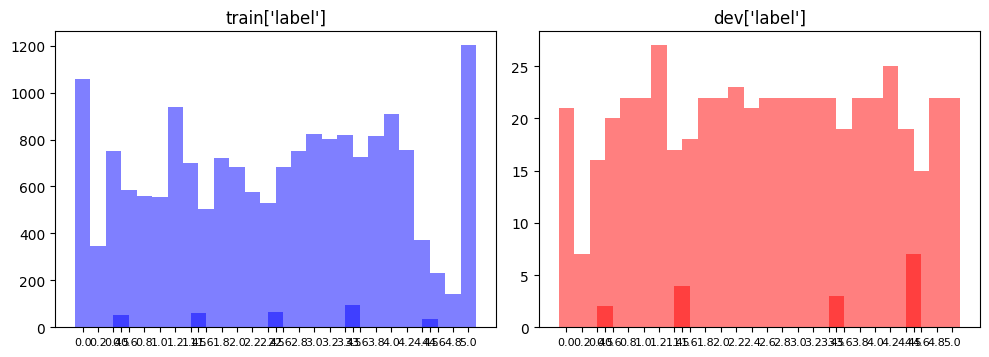

In [49]:
# For train data
feature_train = concat_df['label']
temp_train = feature_train.value_counts()

# For dev data
feature_dev = dev['label']
temp_dev = feature_dev.value_counts()

# subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# train data 그래프
ax1.bar(temp_train.keys(), temp_train.values, width=0.2, color='b', alpha=0.5)
ax1.set_title('train[\'label\']')
ax1.set_xticks(temp_train.keys())
ax1.set_xticklabels(temp_train.keys(), fontsize=8)

# dev data 그래프
ax2.bar(temp_dev.keys(), temp_dev.values, width=0.2, color='r', alpha=0.5)
ax2.set_title('dev[\'label\']')
ax2.set_xticks(temp_dev.keys())
ax2.set_xticklabels(temp_dev.keys(), fontsize=8)

# 레이아웃 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [57]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(concat_df['label'], dev['label'])

print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value}")
# 귀무가설 기각하지 않으므로, 두 분포가 같다고 할 수 있다. (0.193 > 0.05/0.025)

KS Statistic: 0.04648581997533907
P-value: 0.19267188776721156


In [60]:
concat_df.to_csv('v4_train.csv', sep=',', index=False)



---


## 4. 그 외



### 원핫인코딩

In [52]:
df_ = pd.read_csv('train.csv')

In [53]:
df_['source'].unique()
# 스페셜 토큰 추가 - bert[CLS]

array(['nsmc-sampled', 'slack-rtt', 'petition-sampled', 'slack-sampled',
       'nsmc-rtt', 'petition-rtt'], dtype=object)

In [54]:
# 원핫인코딩
df_ = pd.get_dummies(train, columns = ['source']

In [56]:
df_.head()

,id,sentence_1,sentence_2,label,binary-label,source_nsmc-rtt,source_nsmc-sampled,source_petition-rtt,source_petition-sampled,source_slack-rtt,source_slack-sampled
0,boostcamp-sts-v1-train-000,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0,0,1,0,0,0,0
1,boostcamp-sts-v1-train-001,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0,0,0,0,0,1,0
2,boostcamp-sts-v1-train-002,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0,0,0,0,1,0,0
3,boostcamp-sts-v1-train-003,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0,0,0,0,0,0,1
4,boostcamp-sts-v1-train-004,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0,0,0,0,0,0,1


## Reference
- [py-hanspell : 파이썬 한글 맞춤법 검사 라이브러리](https://github.com/ssut/py-hanspell)
- [Symspell을 이용한 한글 맞춤법 교정 2 — 복합어와 띄어쓰기 교정](https://heegyukim.medium.com/symspell%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%ED%95%9C%EA%B8%80-%EB%A7%9E%EC%B6%A4%EB%B2%95-%EA%B5%90%EC%A0%95-2-%EB%B3%B5%ED%95%A9%EC%96%B4%EC%99%80-%EB%9D%84%EC%96%B4%EC%93%B0%EA%B8%B0-%EA%B5%90%EC%A0%95-7605ec2fcebc)
- [spell_checker.py 새로 추가된 passportKey 파라미터에 대한 코드 수정](https://github.com/ssut/py-hanspell/pull/42)
- [문맥을 고려한 한국어 텍스트 데이터 증강](https://github.com/kyle-bong/K-TACC.git)
-[9.5 사이파이를 사용한 검정 - scipy.stats.ks_2samp ](https://datascienceschool.net/02%20mathematics/09.05%20%EC%82%AC%EC%9D%B4%ED%8C%8C%EC%9D%B4%EB%A5%BC%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EA%B2%80%EC%A0%95.html
) : 콜모고로프-스미르노프 검정(Kolmogorov-Smirnov test)
- [KS(Kolmogorov-Smirnov Statistics) 통계량 알아보기](https://data-newbie.tistory.com/874)